# Number of expected triggered hits at different energies

The normalised distributions of the number of PMTs participating in the triggering of the event for simulated muon energies of 10, 100, and 1000 PeV is displayed in this notebook (Figure 2).

This requires the file `KM3-230213A_muon_sim.root` which can be downloaded from the KM3NeT Open Data Center (see `/data` for more detail).

In [6]:
import numpy as np
import pandas as pd
import uproot
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import matplotlib as mpl

from scipy.special import erf

In [7]:
fname = "../data/supplementary/simulations/KM3-230213A_muon_sim.root"

combined_dataset = uproot.open(fname)['MuonEnergyEstimate'].arrays(library = "pd")

In [8]:
plt.rcParams["figure.figsize"] = (16,13.6)

SMALL_SIZE = 24
MEDIUM_SIZE = 28
BIGGER_SIZE = 32

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

The samples contains MC events over a sampling space:
  - [-20%, -15%, -10%, -5%, 0%, +5%, +10%, +15%, +20%] of absorption length
Attributing of weight of 1 to all events is assuming an uniform prior distribution over these systematics

In [9]:
# combined_dataset['w_tot'] = 1
# combined_dataset['w_tot'] = norm_dist(combined_dataset.absorption, 100, 10) * norm_dist(combined_dataset.scattering, 100, 10) * norm_dist(combined_dataset.QE, 100, 10)

point_to_width = {
    80:[77.5,82.5],
    85:[82.5,87.5],
    90:[89,91],
    110:[109,111],
    115:[112.5,117.5],
    120:[117.5,122.4],
}

weight_map = {}

for abs in combined_dataset.Absorption.unique():
    range = None
    if abs in point_to_width:
        range = point_to_width[abs]
    else:
        range = [abs-1, abs +1]
    range = np.array(range)
    range = ((range / 100) - 1 ) * 10 
    integral = erf(range[1]) - erf(range[0])
    print (abs, range, integral)
    weight_map[abs] = integral

    
combined_dataset['w_tot'] = combined_dataset.Absorption.replace(weight_map)

display(combined_dataset)

nb_trig_pmts_dataset = combined_dataset

80.0 [-2.25 -1.75] 0.011865612194136399
85.0 [-1.75 -1.25] 0.06377154296272425
90.0 [-1.1 -0.9] 0.08329685715124968
92.0 [-0.9 -0.7] 0.11910701858541384
94.0 [-0.7 -0.5] 0.15730131602437125
96.0 [-0.5 -0.3] 0.19187311835391918
98.0 [-0.3 -0.1] 0.2161638434408427
100.0 [-0.1  0.1] 0.22492583203656996
102.0 [0.1 0.3] 0.2161638434408427
104.0 [0.3 0.5] 0.19187311835391918
106.0 [0.5 0.7] 0.15730131602437203
108.0 [0.7 0.9] 0.1191070185854135
110.0 [0.9 1.1] 0.08329685715124968
115.0 [1.25 1.75] 0.06377154296272425
120.0 [1.75 2.24] 0.01179256006568008


,Etrue,Edep,Absorption,NTrigPMT,w_tot
0,1.000000e+06,7.214048e+05,80.0,957,0.011866
1,1.000000e+06,1.927958e+05,80.0,272,0.011866
2,1.000000e+06,1.959326e+05,80.0,340,0.011866
3,1.000000e+06,2.746484e+05,80.0,258,0.011866
4,1.000000e+06,5.699227e+05,80.0,575,0.011866
...,...,...,...,...,...
5070568,1.000000e+09,5.619589e+08,120.0,6213,0.011793
5070569,1.000000e+09,2.728113e+08,120.0,5994,0.011793
5070570,1.000000e+09,4.769292e+08,120.0,6176,0.011793
5070571,1.000000e+09,1.670858e+08,120.0,5730,0.011793


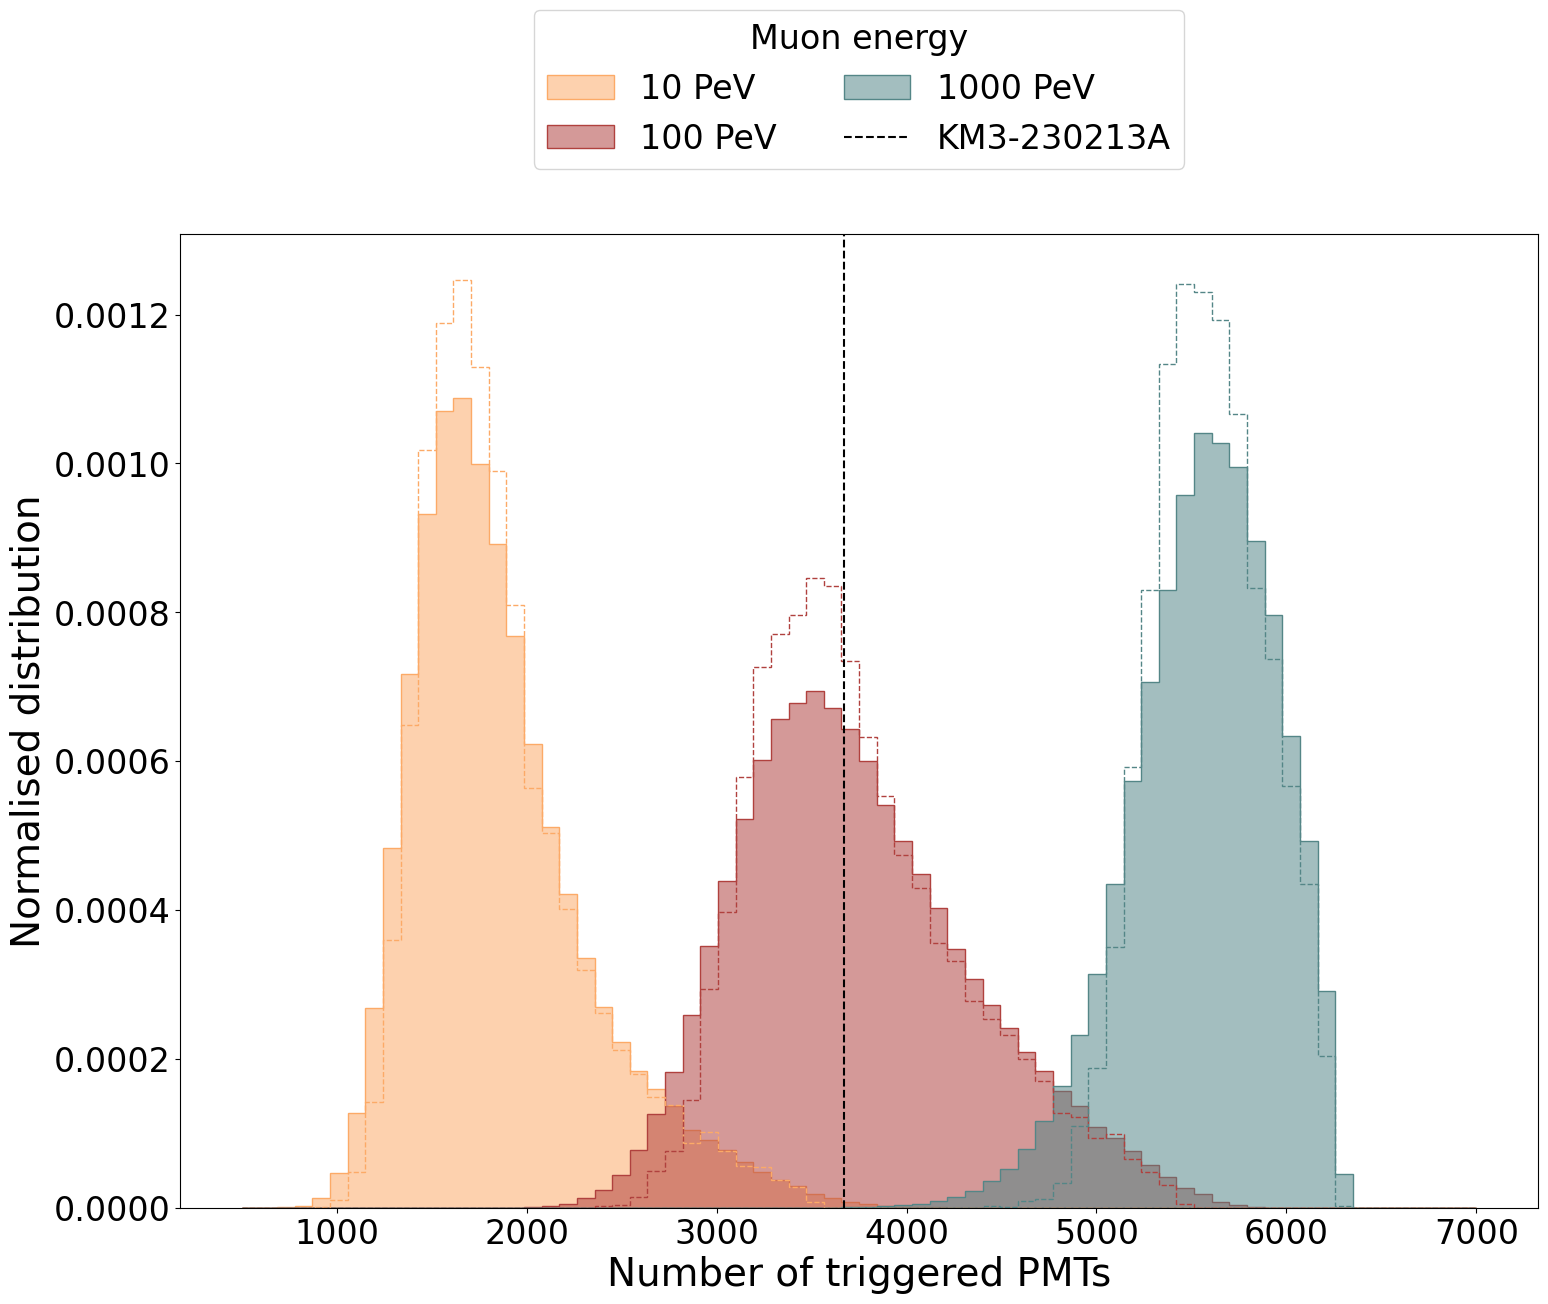

In [10]:
# Plot number of trigger hits
colors = ["#fcaa67","#b0413e",
          #"#ffffc7",
          "#548687","#473335"]

df_no_syst = combined_dataset[combined_dataset.Absorption == 100]
df_syst = combined_dataset #[combined_dataset.absorption == 100]

hist_data = []

measure_trig_pmts = 3672

fig, axe = plt.subplots()

for i, E in enumerate([10,100,1000]):
    color = colors[i]
    color_face = color + "88"
    df = df_syst[df_syst.Etrue == E*1e6]
    
    hist_vals, bin_edges = np.histogram(df.NTrigPMT, bins=np.linspace(500, 7000, 71), weights=df.w_tot, density=True)
    bin_centers = (bin_edges[:-1] + bin_edges[1:])/2  
    
    j = 0
    
    while (j < 70) :
        hist_data.append([E, 'no_syst', bin_centers[j], hist_vals[j]])
        j += 1
        
    axe.hist(df.NTrigPMT, weights = df.w_tot, bins = np.linspace(500,7000,71), histtype = "stepfilled", facecolor = color_face, edgecolor = color, label = f"{E:.0f} PeV", density='True')

for i, E in enumerate([10,100,1000]):
    color = colors[i]
    color_face = color + "88"
    df = df_no_syst[df_no_syst.Etrue == E*1e6]
    
    hist_vals, bin_edges = np.histogram(df.NTrigPMT, bins=np.linspace(500, 7000, 71), weights=df.w_tot, density=True)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2  
    
    j = 0
    
    while (j < 70) :
        hist_data.append([E, 'no_syst', bin_centers[j], hist_vals[j]])
        j += 1

    axe.hist(df.NTrigPMT, weights = df.w_tot, bins = np.linspace(500,7000,71), histtype = "step", facecolor = color_face, edgecolor = color,  density='True', linestyle = 'dashed')

    
axe.axvline(measure_trig_pmts, color ="k", label = "KM3-230213A", linestyle="--")
axe.legend(ncol=2, bbox_to_anchor=(0.5,1.05), loc='lower center', title="Muon energy")
axe.set_xlabel('Number of triggered PMTs')
axe.set_ylabel("Normalised distribution")
plt.tight_layout()

savedata = pd.DataFrame(hist_data, columns=['E', 'syst', 'bin_center', 'hist_val'])
savedata.to_csv('hist_values.csv', index=False)
